In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split

import tensorflow
tensorflow.random.set_seed(1234)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from sklearn.metrics import mean_absolute_error

from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

2024-08-26 16:38:16.289749: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 16:38:16.332425: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 16:38:16.333321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 16:38:17.191847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#cluster_candidates = pd.read_csv('/Users/steven/Documents/CPoint/data/pleiades_candidates.csv')
cluster_candidates = pd.read_csv('../PleiadesTidalTails/data/clean.csv')
del cluster_candidates['Unnamed: 0']

# for i in range(len(cluster_candidates)):
#         #if (np.median(cluster_candidates['ra']) > 300.) or (np.median(cluster_candidates['ra']) < 10.):
#         if cluster_candidates['ra'].values[i] > 300.:
#                 cluster_candidates['ra'].values[i] -= 360
#                 #cluster_candidates.loc[cluster_candidates['ra'] > 300, 'ra'] -= 360

print(len(cluster_candidates))

cluster_candidates_rv = cluster_candidates[~cluster_candidates['radial_velocity'].isna()]
cluster_candidates_rv = cluster_candidates_rv[~cluster_candidates_rv['radial_velocity_error'].isna()]
print(len(cluster_candidates_rv))
cluster_candidates_rv = cluster_candidates_rv[(np.abs(cluster_candidates_rv['radial_velocity']) <= 0.3*np.std(cluster_candidates_rv['radial_velocity']))]
cluster_candidates_rv.info()

1502
509
<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 0 to 1494
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   level_0                     396 non-null    int64  
 1   index                       396 non-null    int64  
 2   source_id                   396 non-null    int64  
 3   ra                          396 non-null    float64
 4   ra_error                    396 non-null    float64
 5   dec                         396 non-null    float64
 6   dec_error                   396 non-null    float64
 7   l                           396 non-null    float64
 8   b                           396 non-null    float64
 9   parallax                    396 non-null    float64
 10  parallax_error              396 non-null    float64
 11  pmra                        396 non-null    float64
 12  pmra_error                  396 non-null    float64
 13  pmdec                       39

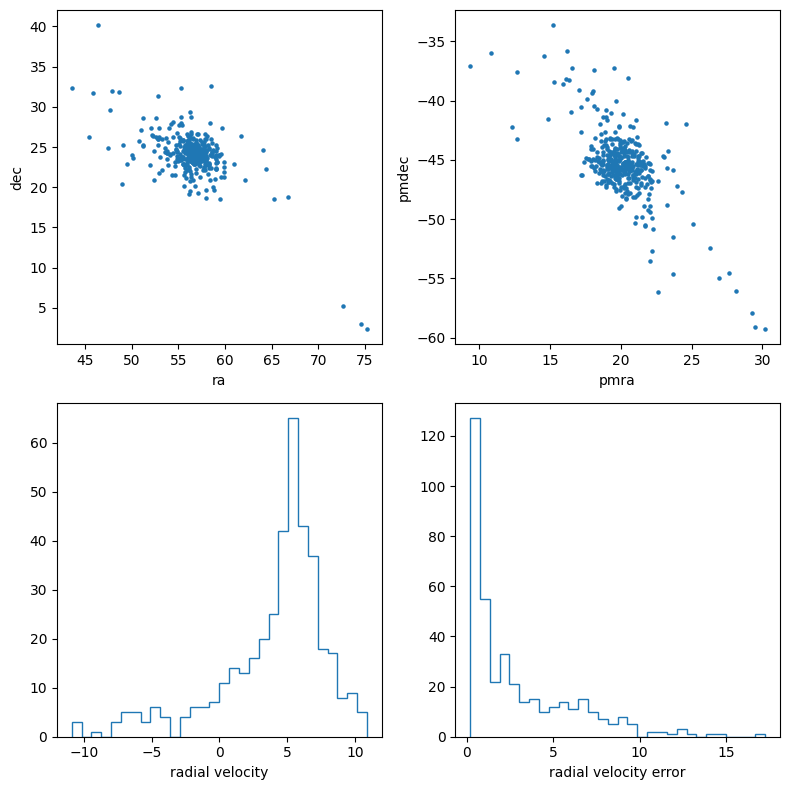

In [5]:
fig, ax = plt.subplots(2,2, figsize=(8,8))

ax[0,0].scatter(cluster_candidates_rv['ra'], cluster_candidates_rv['dec'], s=5)
ax[0,0].set_xlabel('ra')
ax[0,0].set_ylabel('dec')

ax[0,1].scatter(cluster_candidates_rv['pmra'], cluster_candidates_rv['pmdec'], s=5)
ax[0,1].set_xlabel('pmra')
ax[0,1].set_ylabel('pmdec')

ax[1,0].hist(cluster_candidates_rv['radial_velocity'], bins=30, density=False, histtype='step')
ax[1,0].set_xlabel('radial velocity')

ax[1,1].hist(cluster_candidates_rv['radial_velocity_error'], bins=30, histtype='step', density=False)
ax[1,1].set_xlabel('radial velocity error')
fig.tight_layout()
plt.show()

In [6]:
len(cluster_candidates), len(cluster_candidates_rv)

(1502, 396)

In [ ]:
#y_train = np.vstack([y_train, weights_train]).T
#y_val = np.vstack([y_val, weights_val]).T

In [7]:
x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec','parallax']])
#x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec']])
#x_data = np.array(cluster_candidates_rv[['l','b','pmra','pmdec','parallax']])

y_data = np.array(cluster_candidates_rv[['radial_velocity','radial_velocity_error']])
x_data.shape, y_data.shape

((396, 5), (396, 2))

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

# normalizer = Normalizer()
# x_train = normalizer.fit_transform(x_train)
# x_test = normalizer.fit_transform(x_test)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

print('Training shape:', x_train.shape, y_train.shape)
print('Testing shape:', x_test.shape, y_test.shape)

Training shape: (277, 5) (277, 2)
Testing shape: (119, 5) (119, 2)


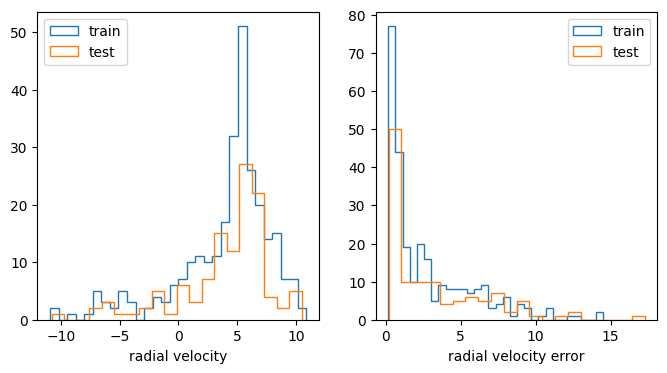

In [9]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(y_train[:,0], bins=30, density=False, histtype='step', label='train')
plt.hist(y_test[:,0], bins=20, density=False, histtype='step', label='test')
plt.legend()
plt.xlabel('radial velocity')

plt.subplot(1,2,2)
plt.hist(y_train[:,1], bins=30, density=False, histtype='step', label='train')
plt.hist(y_test[:,1], bins=20, density=False, histtype='step', label='test')
plt.legend()
plt.xlabel('radial velocity error')
plt.show()

# SVM

In [ ]:
# svr_lin = SVR(kernel = 'linear')
# svr_rbf = SVR(kernel = 'rbf')
# svr_poly = SVR(kernel = 'poly')

# svr_lin.fit(x_train, y_train)
# svr_rbf.fit(x_train, y_train)
# svr_poly.fit(x_train, y_train)

# fig, axes = plt.subplots(1,2, figsize=(8,4))
# axes[0].scatter(x=y_train, y=svr_lin.predict(x_train), s=5)
# axes[0].scatter(x=y_train, y=svr_rbf.predict(x_train), s=5)
# axes[0].scatter(x=y_train, y=svr_poly.predict(x_train), s=5)
# axes[0].set_xlabel("Actual", fontsize=10)
# axes[0].set_ylabel("Predicted",  fontsize=10)
# axes[0].set_title("Training")
# x = np.linspace(*axes[0].get_xlim())
# axes[0].plot(x, x, color='red', ls='--', lw=0.5)

# axes[1].scatter(x=y_test, y=svr_lin.predict(x_test), s=5)
# axes[1].scatter(x=y_test, y=svr_rbf.predict(x_test), s=5)
# axes[1].scatter(x=y_test, y=svr_poly.predict(x_test), s=5)
# axes[1].set_xlabel("Actual", fontsize=10)
# axes[1].set_ylabel("Predicted",  fontsize=10)
# axes[1].set_title("Validation")
# x = np.linspace(*axes[1].get_xlim())
# axes[1].plot(x, x, color='red', ls='--', lw=0.5)
# fig.tight_layout()
# plt.show()

# Gaussian regression

In [ ]:
# kernel = DotProduct() + WhiteKernel()
# gpr = GaussianProcessRegressor(kernel=kernel, random_state=1234).fit(x_train, y_train)
# print(gpr.score(x_train, y_train))

# fig, axes = plt.subplots(1,2, figsize=(8,4))
# axes[0].scatter(x=y_train, y=gpr.predict(x_train), s=5)
# axes[0].set_xlabel("Actual", fontsize=10)
# axes[0].set_ylabel("Predicted",  fontsize=10)
# axes[0].set_title("Training")
# x = np.linspace(*axes[0].get_xlim())
# axes[0].plot(x, x, color='red', ls='--', lw=0.5)

# axes[1].scatter(x=y_test, y=gpr.predict(x_test), s=5)
# axes[1].set_xlabel("Actual", fontsize=10)
# axes[1].set_ylabel("Predicted",  fontsize=10)
# axes[1].set_title("Validation")
# x = np.linspace(*axes[1].get_xlim())
# axes[1].plot(x, x, color='red', ls='--', lw=0.5)
# fig.tight_layout()
# plt.show()

# Neural Network

In [ ]:
tensorflow.keras.backend.clear_session()

In [10]:
# # build the model!
# model = Sequential()
# model.add(Dense(1000, input_shape=(x_train.shape[1],), activation='relu')) # (features,)
# model.add(Dropout(0.2))
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(250, activation='relu'))
# model.add(Dense(1, activation='linear')) # output node
# model.summary() # see what your model looks like

#initializer = tensorflow.keras.initializers.glorot_uniform(seed=1)
#kernel_initializer=initializer

# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(30, activation='relu'),
#     Dense(30, activation='relu'),
#     #BatchNormalization(),
#     Dense(30, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)),
#     Dropout(0.3),
#     Dense(30, activation='relu', kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)),
#     #BatchNormalization(),
#     Dense(30, activation='relu'),
#     Dense(1, activation='linear')
# ])

model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(100, activation='relu'),
    Dense(200, activation='relu'),
    Dense(400, activation='relu'),
    Dropout(0.3),
    Dense(200, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='linear')
])

# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(500, activation='tanh', kernel_initializer=initializer),
#     Dense(250, activation='tanh'),
#     Dropout(0.2),
#     Dense(125, activation='tanh'),
#     Dropout(0.2),
#     Dense(50, activation='tanh'),
#     Dense(1, activation='linear')
# ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               600       
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 400)               80400     
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               80200     
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 1)                 1

In [11]:
# def LikelihoodLossFunction(y_true, y_pred):
#     # shape of y_pred should be (nsamples, 2)
#     # the first column should be the line-of-sight velocity
#     # the second column is the uncertainty
#     SIGMA = K.abs(y_pred[:, 1]) + 1e-6
#     LOC = y_pred[:, 0]
#     X = y_true[:, 0]
#     weights = y_true[:,1]
#     ARG = K.pow((X - LOC),2) / (2 * K.pow(SIGMA,2))
#     PREFACT = K.log(K.pow(2 * np.pi * K.pow(SIGMA,2), -0.5))
#     return K.mean((ARG - PREFACT) * weights)

# def custom_loss_(y_true, y_pred):
#     return tensorflow.reduce_mean(tensorflow.square(y_true - y_pred))

def custom_loss(y_true, y_pred):
    v_los =  y_true[:,0]
    sigma_los = y_true[:,1]
    v_los_pred = y_pred[:,0]
    ARG = tensorflow.pow((v_los - v_los_pred), 2) / (2 * tensorflow.pow(sigma_los, 2))
    PREFACT = tensorflow.math.log(tensorflow.pow(2 * np.pi * tensorflow.pow(sigma_los, 2), -0.5))
    return tensorflow.reduce_mean(ARG - PREFACT)

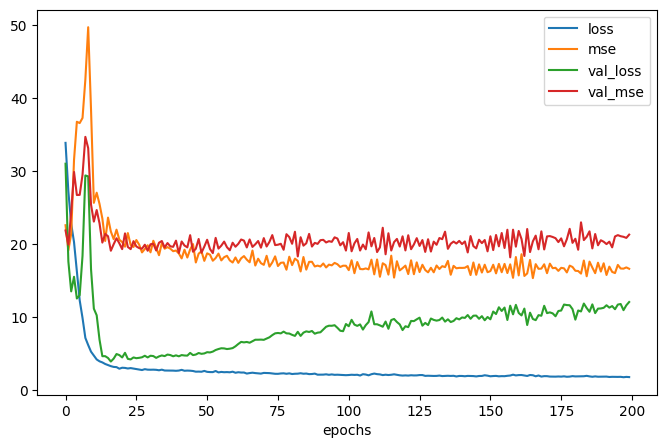

In [12]:
#metrics = ['mean_squared_error', tensorflow.keras.losses.MAE, tensorflow.keras.metrics.R2Score()]
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mae','mse'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=tensorflow.keras.losses.MeanSquaredError(), metrics=['mae','mse'])
model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=custom_loss, metrics=['mse'])
history = model.fit(x_train, y_train, epochs=200, batch_size=100, validation_data=(x_test, y_test), verbose=0)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel('epochs')
plt.show()

4/4 [==============================] - 0s 2ms/step


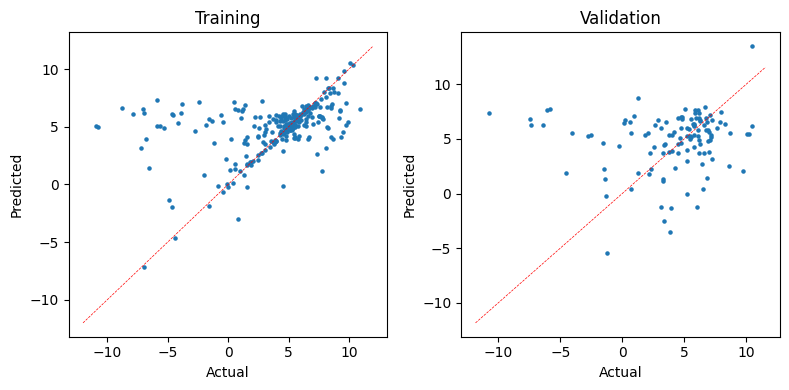

In [13]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].scatter(y_train[:,0], model.predict(x_train).flatten(), s=5)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)

axes[1].scatter(x=y_test[:,0], y=model.predict(x_test).flatten(), s=5)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Validation")
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red', ls='--', lw=0.5)
fig.tight_layout()
plt.show()

In [14]:
pred = model.predict(x_test)
trainpreds = model.predict(x_train)

print('Train:',mean_absolute_error(y_train[:,0], trainpreds)) # train
print('Test:',mean_absolute_error(y_test[:,0], pred)) # test

9/9 [==============================] - 0s 2ms/step
Train: 1.9944237787799606
Test: 3.1141362461191204


# Predict on all data

(1502, 5)
47/47 [==============================] - 0s 1ms/step


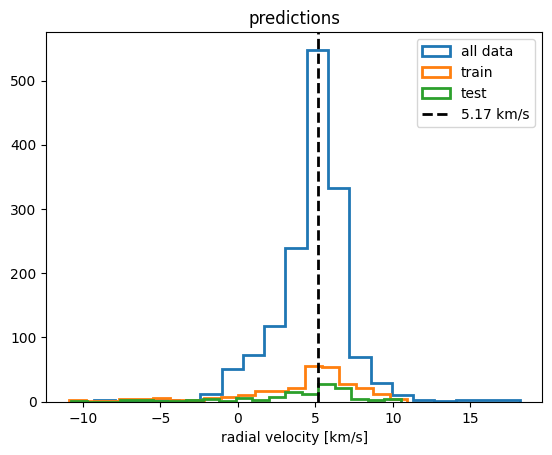

In [17]:
x_ = np.array(cluster_candidates[['ra','dec','pmra','pmdec','parallax']])
#x_ = np.array(cluster_candidates[['l','b','pmra','pmdec']])
x_ = scaler.fit_transform(x_)
print(x_.shape)

y_pred = model.predict(x_).flatten()
v_mean = np.median(y_pred)

plt.title('predictions')
plt.hist(y_pred, bins=20, label='all data', histtype='step', lw=2)
plt.hist(y_train[:,0], bins=20, label='train', histtype='step', lw=2)
plt.hist(y_test[:,0], bins=20, label='test', histtype='step', lw=2)
plt.axvline(v_mean, label='{:.2f} km/s'.format(v_mean), lw=2, ls='dashed', c='k')
plt.legend()
plt.xlabel('radial velocity [km/s]')
plt.show()